In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [3]:
trans=transforms.ToTensor()
mnist_train=torchvision.datasets.FashionMNIST(root="./data/01_DataSet_FashionMNIST",train=True,transform=trans,download=True)
mnist_test=torchvision.datasets.FashionMNIST(root="./data/01_DataSet_FashionMNIST",train=False,transform=trans,download=True)
print(len(mnist_train))
print(len(mnist_test))
print(mnist_train[0][0].shape)
print(mnist_train[0][1])

60000
10000
torch.Size([1, 28, 28])
9


Figure(1350x300)
[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:>]]
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]
i: 0
ax,img: AxesSubplot(0.125,0.53;0.0731132x0.35) tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

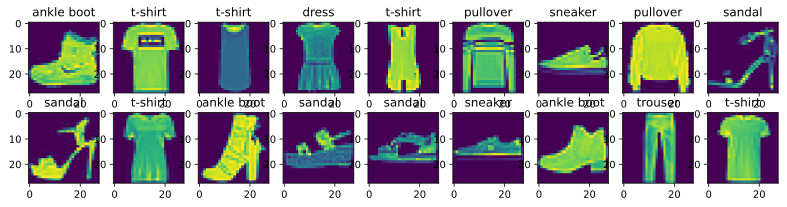

In [4]:
def get_fashion_mnist_labels(labels):
    text_labels=['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    print(_)
    print(axes)
    axes=axes.flatten()
    print(axes)
    for i,(ax,img) in enumerate(zip(axes,imgs)):
        if(i<1):
            print("i:",i)
            print("ax,img:",ax,img)
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
            ax.set_title(titles[i])
        else:
            ax.imshow(img)
X,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y))

In [8]:
batch_size=256
def get_dataloader_workers():
    return 4
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())
timer=d2l.Timer()
for X,y in train_iter:
    continue
f'{timer.stop():.2f}sec'

'2.41sec'

In [9]:
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_iter=data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=get_dataloader_workers())

In [10]:
num_inputs=784
num_outputs=10
w=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)
print(w.shape)
print(b.shape)

torch.Size([784, 10])
torch.Size([10])


In [11]:
def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)
    return X_exp/partition
def net(X):
    return softmax(torch.matmul(X.reshape(-1,w.shape[0]),w)+b)
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric=Accumulator(2)
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

class Accumulator:
    """在n个变量上累加"""
    def __init__(self,n):
        self.data = [0,0] * n
        
    def add(self, *args):
        self.data = [a+float(b) for a,b in zip(self.data,args)] # zip函数把两个列表第一个位置元素打包、第二个位置元素打包....
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self,idx):
        return self.data[idx]
print(evaluate_accuracy(net,test_iter))

0.154


In [13]:
from IPython import display
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)): 
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)         
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [12]:
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat= net(X)
        l=loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().nummel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]

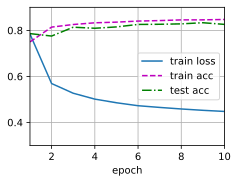

In [18]:
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
     animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],       
                       legend=['train loss','train acc','test acc'])
     for epoch in range(num_epochs):
        train_metrics=train_epoch_ch3(net,train_iter,loss,updater)
        test_acc=evaluate_accuracy(net,test_iter)
        animator.add(epoch+1,train_metrics+(test_acc,))
     train_loss,train_acc=train_metrics
lr=0.1
def updater(batch_size):
    return d2l.sgd([w,b],lr,batch_size)
num_epochs=10
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

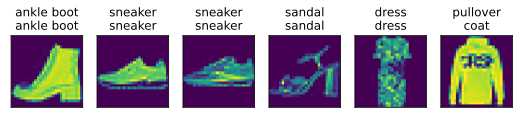

In [20]:
def predict_ch3(net,test_iter,n=6):
    for X, y in test_iter: 
        break # 仅拿出一批六个数据
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
    
predict_ch3(net,test_iter)

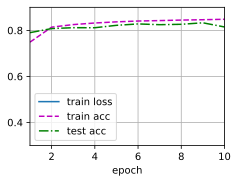

In [18]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size=256
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_iter=data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=get_dataloader_workers())
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weight)
print(net.apply(init_weight))
loss=nn.CrossEntropyLoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.1)
num_epochs=10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)